# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [3]:
sc

In [4]:
genome_tags_RDD = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(genome_tags_RDD.map(itemgetter("tagId", "tag")).collect())

In [5]:
len(tag2name)

1128

In [6]:
genome_scores_RDD = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
# genome_scores = data.collect() # RDD IS TOO BIG

### Exercise 3.1 

In [7]:
tag2name

{1: '007',
 2: '007 (series)',
 3: '18th century',
 4: '1920s',
 5: '1930s',
 6: '1950s',
 7: '1960s',
 8: '1970s',
 9: '1980s',
 10: '19th century',
 11: '3d',
 12: '70mm',
 13: '80s',
 14: '9/11',
 15: 'aardman',
 16: 'aardman studios',
 17: 'abortion',
 18: 'absurd',
 19: 'action',
 20: 'action packed',
 21: 'adaptation',
 22: 'adapted from:book',
 23: 'adapted from:comic',
 24: 'adapted from:game',
 25: 'addiction',
 26: 'adolescence',
 27: 'adoption',
 28: 'adultery',
 29: 'adventure',
 30: 'affectionate',
 31: 'afi 100',
 32: 'afi 100 (laughs)',
 33: 'afi 100 (movie quotes)',
 34: 'africa',
 35: 'afterlife',
 36: 'aging',
 37: 'aids',
 38: 'airplane',
 39: 'airport',
 40: 'alaska',
 41: 'alcatraz',
 42: 'alcoholism',
 43: 'alien',
 44: 'alien invasion',
 45: 'aliens',
 46: 'allegory',
 47: 'almodovar',
 48: 'alone in the world',
 49: 'alter ego',
 50: 'alternate endings',
 51: 'alternate history',
 52: 'alternate reality',
 53: 'alternate universe',
 54: 'amazing cinematography',

In [8]:
movies_rdd = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movies_rdd.map(lambda movie: movie['movieId']).max()

131262

In [9]:
movies = movies_rdd.collect()

In [10]:
len(movies)

27278

In [11]:
movies

[{'genres': ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
  'movieId': 1,
  'title': 'Toy Story (1995)'},
 {'genres': ['Adventure', 'Children', 'Fantasy'],
  'movieId': 2,
  'title': 'Jumanji (1995)'},
 {'genres': ['Comedy', 'Romance'],
  'movieId': 3,
  'title': 'Grumpier Old Men (1995)'},
 {'genres': ['Comedy', 'Drama', 'Romance'],
  'movieId': 4,
  'title': 'Waiting to Exhale (1995)'},
 {'genres': ['Comedy'],
  'movieId': 5,
  'title': 'Father of the Bride Part II (1995)'},
 {'genres': ['Action', 'Crime', 'Thriller'],
  'movieId': 6,
  'title': 'Heat (1995)'},
 {'genres': ['Comedy', 'Romance'], 'movieId': 7, 'title': 'Sabrina (1995)'},
 {'genres': ['Adventure', 'Children'],
  'movieId': 8,
  'title': 'Tom and Huck (1995)'},
 {'genres': ['Action'], 'movieId': 9, 'title': 'Sudden Death (1995)'},
 {'genres': ['Action', 'Adventure', 'Thriller'],
  'movieId': 10,
  'title': 'GoldenEye (1995)'},
 {'genres': ['Comedy', 'Drama', 'Romance'],
  'movieId': 11,
  'title': 'Americ

In [12]:
genome_scores_RDD.getNumPartitions()

6

In [13]:
smaller_genome_scores_RDD = genome_scores_RDD.sample(True, 0.01)

In [14]:
genome_scores = smaller_genome_scores_RDD.collect()

In [15]:
len(genome_scores)

117449

In [16]:
genome_scores

[{'movieId': 1, 'relevance': 0.016500000000000015, 'tagId': 112},
 {'movieId': 1, 'relevance': 0.16999999999999998, 'tagId': 267},
 {'movieId': 1, 'relevance': 0.29974999999999996, 'tagId': 449},
 {'movieId': 1, 'relevance': 0.15425, 'tagId': 768},
 {'movieId': 1, 'relevance': 0.04375000000000001, 'tagId': 1111},
 {'movieId': 2, 'relevance': 0.11025000000000001, 'tagId': 5},
 {'movieId': 2, 'relevance': 0.1235, 'tagId': 238},
 {'movieId': 2, 'relevance': 0.05375000000000002, 'tagId': 285},
 {'movieId': 2, 'relevance': 0.08550000000000002, 'tagId': 326},
 {'movieId': 2, 'relevance': 0.046499999999999986, 'tagId': 507},
 {'movieId': 2, 'relevance': 0.03125, 'tagId': 607},
 {'movieId': 2, 'relevance': 0.27725, 'tagId': 663},
 {'movieId': 2, 'relevance': 0.14575, 'tagId': 682},
 {'movieId': 2, 'relevance': 0.03075, 'tagId': 1015},
 {'movieId': 2, 'relevance': 0.09150000000000003, 'tagId': 1033},
 {'movieId': 2, 'relevance': 0.01874999999999999, 'tagId': 1128},
 {'movieId': 3, 'relevance': 

In [17]:
M_matrix = np.zeros( (len(tag2name), len(movies)) ) 
M_matrix.shape

(1128, 27278)

In [18]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry

M_Matrix_entity = genome_scores_RDD.map(lambda score: MatrixEntry(score["tagId"] - 1, score["movieId"] - 1, score["relevance"]))
M_Matrix_transposed_entity = genome_scores_RDD.map(lambda score: MatrixEntry(score["movieId"] - 1, score["tagId"] - 1, score["relevance"]))

In [19]:
M_Matrix_entity.first()

MatrixEntry(0, 0, 0.025000000000000022)

In [20]:
M_Matrix_coord = CoordinateMatrix(M_Matrix_entity)
M_Matrix_transposed_coord = CoordinateMatrix(M_Matrix_transposed_entity)

In [21]:
from pyspark.mllib.stat import Statistics

M_transposed_row = M_Matrix_transposed_coord.toRowMatrix()

# Compute column summary statistics.
summary = Statistics.colStats(M_transposed_row.rows)
print(summary.mean())  # a dense vector containing the mean value for each column
print(summary.variance())  # column-wise variance
print(summary.numNonzeros())  # number of nonzeros in each column

[ 0.04593457  0.04555156  0.06940533 ...,  0.04511629  0.11118832
  0.03019745]
[ 0.00490042  0.00374098  0.01184989 ...,  0.0188282   0.01105378
  0.00658031]
[ 10381.  10381.  10381. ...,  10381.  10381.  10381.]


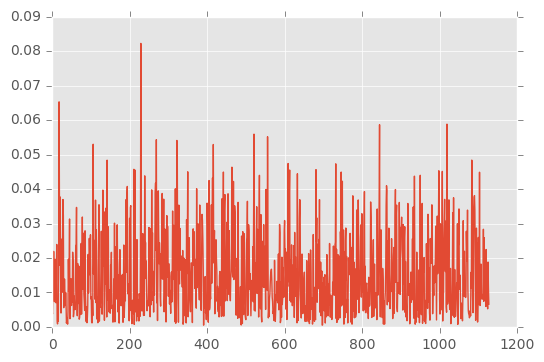

In [22]:
plt.plot(summary.variance())

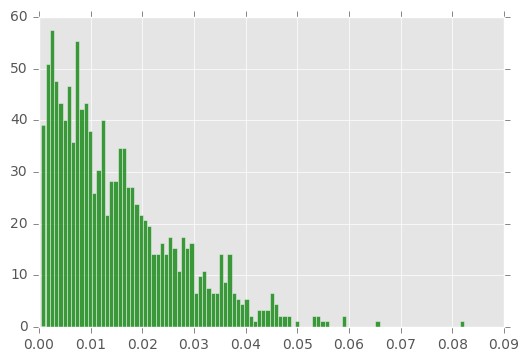

In [23]:
plt.hist(summary.variance(), bins=100, normed=1, facecolor='green', alpha=0.75)
plt.show()


## Eigenvalues

In [24]:
from pyspark.sql import Row
from pyspark.mllib.linalg import Vectors
row = Row("features") # Or some other column name

M_matrix_row = M_Matrix_coord.toRowMatrix()
M_matrix_row_dense = M_matrix_row.rows.map(lambda x: Vectors.dense(x.toArray()) )
M_matrix_df = M_matrix_row_dense.map(row).toDF()

TAKEN FROM: http://stackoverflow.com/questions/33428589/pyspark-and-pca-how-can-i-extract-the-eigenvectors-of-this-pca-how-can-i-calcu


In [25]:
import numpy as np

def estimateCovariance(df):
    """Compute the covariance matrix for a given dataframe.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        df:  A Spark dataframe with a column named 'features', which (column) consists of DenseVectors.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input dataframe.
    """
    m = df.select(df['features']).map(lambda x: x[0]).mean()
    dfZeroMean = df.select(df['features']).map(lambda x:   x[0]).map(lambda x: x-m)  # subtract the mean

    return dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()

In [ ]:
M_matrix_df.first()

In [27]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=2, inputCol="features", outputCol="pca")
model = pca.fit(M_matrix_df)
transformed = model.transform(M_matrix_df)

KeyboardInterrupt: 

In [26]:
cov_matrix = estimateCovariance(M_matrix_df)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: ResultStage 17 (sum at <ipython-input-25-1764926499fb>:20) has failed the maximum allowable number of times: 4. Most recent failure reason: org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 2
	at org.apache.spark.MapOutputTracker$$anonfun$org$apache$spark$MapOutputTracker$$convertMapStatuses$2.apply(MapOutputTracker.scala:548)
	at org.apache.spark.MapOutputTracker$$anonfun$org$apache$spark$MapOutputTracker$$convertMapStatuses$2.apply(MapOutputTracker.scala:544)
	at scala.collection.TraversableLike$WithFilter$$anonfun$foreach$1.apply(TraversableLike.scala:772)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:108)
	at scala.collection.TraversableLike$WithFilter.foreach(TraversableLike.scala:771)
	at org.apache.spark.MapOutputTracker$.org$apache$spark$MapOutputTracker$$convertMapStatuses(MapOutputTracker.scala:544)
	at org.apache.spark.MapOutputTracker.getMapSizesByExecutorId(MapOutputTracker.scala:155)
	at org.apache.spark.shuffle.BlockStoreShuffleReader.read(BlockStoreShuffleReader.scala:47)
	at org.apache.spark.rdd.ShuffledRDD.compute(ShuffledRDD.scala:98)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:227)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1433)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1421)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1420)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1420)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1260)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1601)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1590)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:622)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1856)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1869)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1882)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1953)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:934)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:323)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:933)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)


In [ ]:
from numpy.linalg import eigh

def pca(df, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        df: A Spark dataframe with a 'features' column, which (column) consists of DenseVectors.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
        scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
        rows equals the length of the arrays in the input `RDD` and the number of columns equals
        `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
        of length `k`.  Eigenvalues is an array of length d (the number of features).
     """
    cov = estimateCovariance(df)
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvals
    score = df.select(df['features']).map(lambda x: x[0]).map(lambda x: np.dot(x, components.T) )
    # Return the `k` principal components, `k` scores, and all eigenvalues

    return components.T, score, eigVals

## Archive

In [ ]:
from pyspark.mllib.feature import PCA as PCAmllib
from pyspark.mllib.linalg import Vectors


rdd = sc.parallelize([
    Vectors.dense([1, 2, 0]),
    Vectors.dense([2, 0, 1]),
    Vectors.dense([0, 1, 0])])

model = PCAmllib(2).fit(rdd)
transformed = model.transform(rdd)

In [ ]:
transformed.first()

In [ ]:
from pyspark.ml.feature import PCA as PCAml
from pyspark.mllib.linalg import Vectors

df = sqlContext.createDataFrame([
   (Vectors.dense([1, 2, 0]),),
   (Vectors.dense([2, 0, 1]),),
   (Vectors.dense([0, 1, 0]),)], ("features", ))

pca = PCAml(k=2, inputCol="features", outputCol="pca")
model = pca.fit(df)
transformed = model.transform(df)

In [ ]:
transformed.first()

In [ ]:
df

In [ ]:
M_Matrix_DF = M_Matrix_entity.toDF()
M_Matrix_DF

In [ ]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["value"],
    outputCol="features")

output = assembler.transform(M_Matrix_DF)
print("Assembled columns 'hour', 'mobile', 'userFeatures' to vector column 'features'")
output.select("features").show(truncate=False)

In [ ]:
model = PCAmllib(2).fit(M_Matrix_entity)
transformed = model.transform(M_Matrix_entity)
transformed.first()